In [ ]:
%tensorflow_version 2.x
%pip install tensorflow-addons==0.8.3
import tensorflow
print(tensorflow.__version__)

2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Copy the uploaded zip file in google drive to colab session for faster processing.
!cp -r '/content/drive/My Drive/notebooks/fundus/A. Segmentation.zip' '/'
!cp -r '/content/drive/My Drive/notebooks/fundus/B. Disease Grading.zip' '/'
!cp -r '/content/drive/My Drive/notebooks/fundus/hed_pretrained_bsds.caffemodel' '/'
!cp -r '/content/drive/My Drive/notebooks/fundus/deploy_layer1.prototxt' '/'
#Unzip the data in  colab session for faster processing.
!unzip '/A. Segmentation.zip' -d '/'

!unzip '/B. Disease Grading.zip' -d '/unlabeled/'

Archive:  /A. Segmentation.zip
replace /A. Segmentation/1. Original Images/a. Training Set/IDRiD_01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /B. Disease Grading.zip
replace /unlabeled/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from keras.preprocessing.image import ImageDataGenerator
tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE

import cv2 as cv
import random

In [ ]:
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

cv.dnn_registerLayer('Crop', CropLayer) 
net = cv.dnn.readNetFromCaffe("/deploy_layer1.prototxt", "/hed_pretrained_bsds.caffemodel")   

In [ ]:
clahe = cv.createCLAHE(clipLimit=12.0, tileGridSize=(16,16))
class ImageHelper(object):
    def normalize_img(self,img):
        img = tf.cast(img, dtype=tf.float32)
        # Map values in the range [-1, 1]
        return (img / 127.5) - 1.0

    def preprocess_image(self,img):        
        # Only resizing and normalization for the test images.              
        img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])        
        img = self.normalize_img(img)
       
        return img

    
    def get_train_image(self, batch_size=1):
        data = load('maps_256.npz')
        # unpack arrays and return      
        train_img = (
          tf.data.Dataset.from_tensor_slices(data['arr_2']).map(self.preprocess_image, num_parallel_calls=autotune)
          .cache()      
          .batch(batch_size)
        )
        train_msk = (
          tf.data.Dataset.from_tensor_slices(data['arr_1']).map(self.preprocess_image, num_parallel_calls=autotune)
          .cache()      
          .batch(batch_size)
        )
        unlabeled_img = (
          tf.data.Dataset.from_tensor_slices(data['arr_3']).map(self.preprocess_image, num_parallel_calls=autotune)
          .cache()      
          .batch(batch_size)
        )
        return (train_img, train_msk, unlabeled_img)        

    def get_testing_image(self, batch_size=1):
        data = load('maps_256.npz')
        
        # unpack arrays
        imgs_org, imgs_msk = data['arr_2'], data['arr_1']
        img_list, msk_list = list(), list() 
        for i in range(4):  
          index = np.random.random_integers(len(imgs_org)-1)  
          img_list.append(imgs_org[index])                
          msk_list.append(imgs_msk[index])

        test_img = (
          tf.data.Dataset.from_tensor_slices(img_list)  .map(self.preprocess_image, num_parallel_calls=autotune)
          .cache()      
          .batch(batch_size)
        )
        test_msk = (
          tf.data.Dataset.from_tensor_slices(msk_list).map(self.preprocess_image, num_parallel_calls=autotune)
          .cache()      
          .batch(batch_size)
        )
        return (test_img, test_msk)        

    def get_edge_image(self, img):
      img = (img).astype(np.uint8)
      org_image_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
      final_image = clahe.apply(org_image_gray)
      final_image = cv.medianBlur(final_image,3)                
      final_image = cv.cvtColor(final_image, cv.COLOR_BGR2RGB) 

      blob = cv.dnn.blobFromImage(final_image, scalefactor=0.1, size=(700, 700),
        mean=(110, 54 , 9),
        swapRB=False, crop=False)
      # set the blob as the input to the network and perform a forward pass
      # to compute the edges
      net.setInput(blob)
      hed = net.forward()
      
      hed = cv.resize(hed[0, 0], (700, 700))
      hed = cv.cvtColor(hed, cv.COLOR_BGR2RGB)
      return hed    

    def compress_images(self,path, size=(1024,1024)):
      zip_filename = 'maps_256.npz'
      
      if not os.path.isfile(zip_filename): 
        src_list, tar_list, edge_list, unlabeled_list = list(), list(), list(), list()
        path = '/A. Segmentation/1. Original Images/a. Training Set/'
        mask_path = "/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages/" 
        unlabeled_path = "/unlabeled/B. Disease Grading/1. Original Images/a. Training Set/"
        labeled_dir = listdir(path)
        unlabeled_dir = listdir(unlabeled_path)
        total_label = len(labeled_dir)
        clahe = cv.createCLAHE(clipLimit=12.0, tileGridSize=(32,32))
        datagen = ImageDataGenerator(rotation_range=30)
        # enumerate filenames in directory, assume all are images
        for filename in labeled_dir:
            #if len(src_list) > 2:
            #continue
          # load and resize the image
            r = random.randint(0,total_label-1)
            #print( unlabeled_path + unlabeled_dir[r] )
            unlabeled_pixels = load_img(unlabeled_path +  unlabeled_dir[r], target_size=size)
            org_pixels = load_img(path + filename, target_size=size)
            # convert to numpy array
            unlabeled_pixels = img_to_array(unlabeled_pixels)
            org_pixels = img_to_array(org_pixels)
            mask = mask_path+filename.split('.')[0]+'_HE.tif'
            try:
              #print(cv.mean(org_pixels))
              org_edge = self.get_edge_image(org_pixels)  
              unlabeled_edge = self.get_edge_image(unlabeled_pixels)  
             
              mask_pixels = load_img(mask , target_size=size)  
              # convert to numpy array
              mask_pixels = img_to_array(mask_pixels)  

              
              #edge_mask = img_to_array( edge_mask)  
              

              #mask_pixels = mask_pixels + org_pixels

              #org_pixels = get_edge_image(org_pixels)

              #org_pixels_dim = expand_dims(org_pixels, 0)  
              #mask_pixels_dim = expand_dims(mask_pixels, 0)  
              src_list.append(org_pixels)  
              tar_list.append(mask_pixels)     
              edge_list.append(org_edge)
              unlabeled_list.append(unlabeled_edge)

              #org_pixels = expand_dims(org_pixels, 0)
              #it = datagen.flow(org_pixels, batch_size=1)
              
              #aug_edge_mask = self.get_edge_image( aug_image) 
              #aug_edge_mask = img_to_array( aug_edge_mask)   
              #aug_image = get_edge_image(aug_image)
              #mask_pixels = expand_dims(mask_pixels, 0)
              #it = datagen.flow(mask_pixels, batch_size=1)

              #aug_image = tf.image.rot90(org_pixels, k=3)
              #aug_mask = tf.image.rot90(mask_pixels, k=3)
        
              #src_list.append(aug_image)
              #tar_list.append(aug_mask)
              #edge_list.append(aug_image)
            except:
              print("Oops!", sys.exc_info()[0], "occurred.")       

        print('Loaded: ', asarray(src_list).shape, asarray(tar_list).shape, asarray(edge_list).shape,asarray(unlabeled_list).shape)
        # save as compressed numpy array
        
        savez_compressed(zip_filename, asarray(src_list), asarray(tar_list), asarray(edge_list),asarray(unlabeled_list))
        print('Saved dataset: ', zip_filename)  
      

In [ ]:

# Define the standard image size.
orig_img_size = (700, 700)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1




In [ ]:
from os import listdir
import os.path
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import sys
from numpy import load
from numpy import asarray
from numpy import expand_dims
from numpy import savez_compressed

import cv2 as cv

In [ ]:
image_helper = ImageHelper()
image_helper.compress_images('/A. Segmentation/1. Original Images/a. Training Set/')
print("getting train images…")
train_img, train_msk, train_unlabeled = image_helper.get_train_image(batch_size)
print("getting test images…")
test_img, test_msk = image_helper.get_testing_image(batch_size)
print("plotting images images…")

Oops! <class 'FileNotFoundError'> occurred.
Loaded:  (53, 1024, 1024, 3) (53, 1024, 1024, 3) (53, 700, 700, 3) (53, 700, 700, 3)
Saved dataset:  maps_256.npz
getting train images…
getting test images…


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: This function is deprecated. Please call randint(1, 52 + 1) instead


plotting images images…


[INFO] performing holistically-nested edge detection...
[INFO] performing holistically-nested edge detection...
[INFO] performing holistically-nested edge detection...
[INFO] performing holistically-nested edge detection...


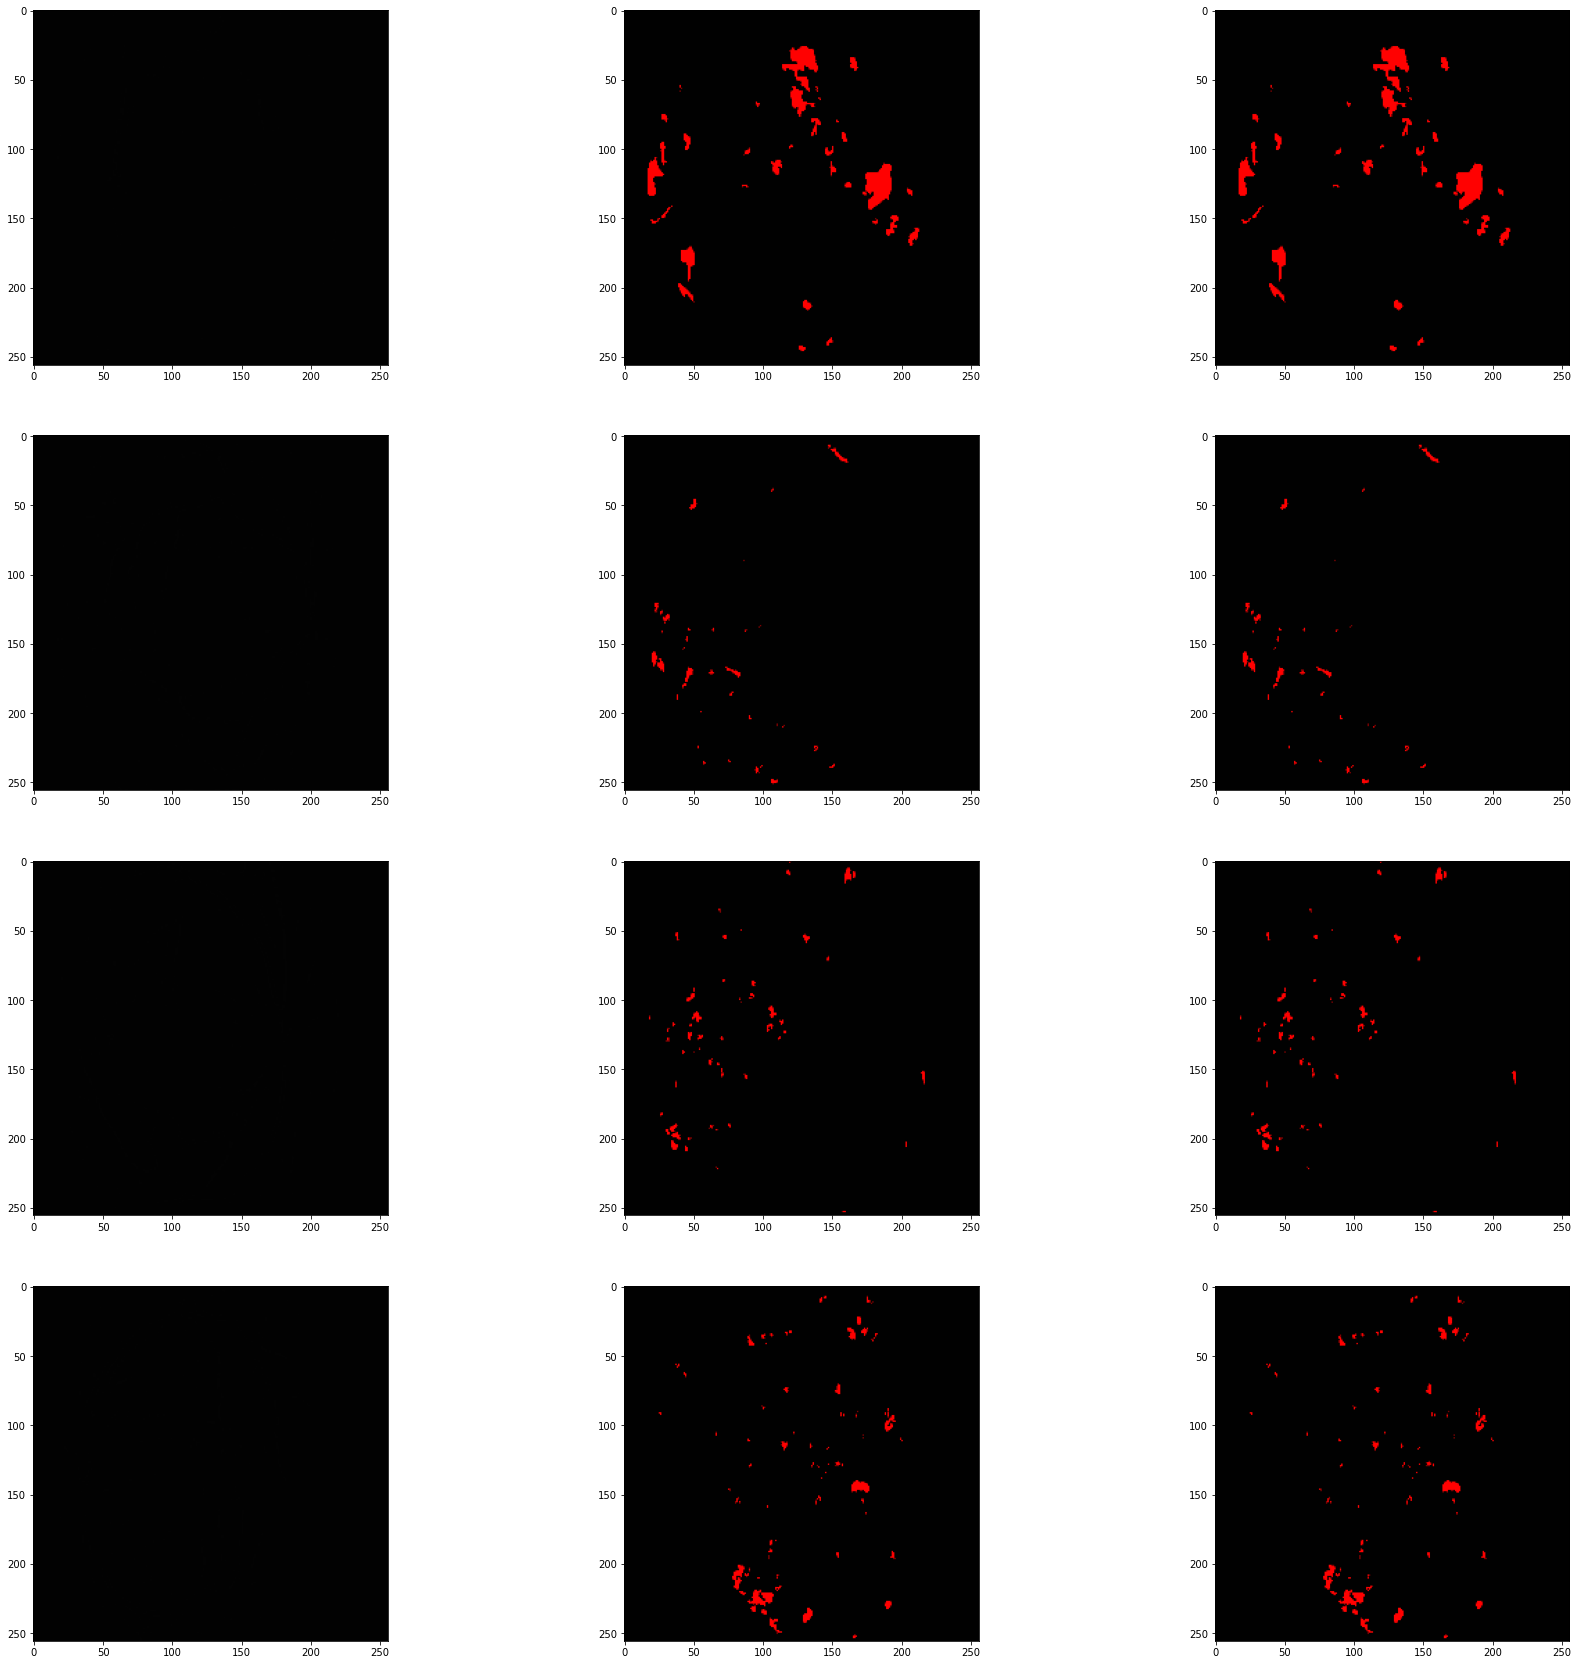

In [ ]:



#Visualize some samples
_, ax = plt.subplots(4, 3, figsize=(30, 30))
for i, samples in enumerate(zip(train_img.take(4), train_msk.take(4))):    
    #img = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    #msk = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    img = ((samples[0][0] * 255).numpy()).astype(np.uint8)
    msk = ((samples[1][0] * 255).numpy()).astype(np.uint8)
    #org_image_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #final_image = clahe.apply(org_image_gray)
    #final_image = cv.medianBlur(final_image,3)                
    #final_image = cv.cvtColor(final_image, cv.COLOR_BGR2RGB) 

    #blob = cv.dnn.blobFromImage(final_image, scalefactor=0.1, size=(700, 700),mean=(0, 0, 0),swapRB=False, crop=False)
    # set the blob as the input to the network and perform a forward pass
    # to compute the edges
    print("[INFO] performing holistically-nested edge detection...")
    #net.setInput(blob)
    #hed = net.forward()
    #hed = cv.resize(hed[0, 0], (700, 700))

    #hed = (255 * hed).astype("uint8")
    #hed = image_helper.get_edge_image(img)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(msk,cmap='binary_r')
    ax[i, 2].imshow(msk)
plt.show()

In [ ]:

#Visualize some samples
_, ax = plt.subplots(4, 3, figsize=(10, 15))
for i, samples in enumerate(zip(train_img.take(4), train_msk.take(4))):    
    img = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    msk = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    
    blob = cv.dnn.blobFromImage(img, scalefactor=1.0, size=(256, 256),
      mean=(104.00698793, 116.66876762, 122.67891434),
      swapRB=False, crop=False)
    # set the blob as the input to the network and perform a forward pass
    # to compute the edges
    print("[INFO] performing holistically-nested edge detection...")
    net.setInput(blob)
    hed = net.forward()
    hed = cv.resize(hed[0, 0], (256, 256))
    hed = (255 * hed).astype("uint8")

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(hed)
    ax[i, 2].imshow(msk)
plt.show()

In [ ]:

class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [ ]:

def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


In [ ]:

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


In [ ]:

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y, real_unlabeled = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            fake_y_unlabeled = self.gen_G(real_unlabeled, training=True)


            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)
            cycled_x_unlabelled = self.gen_F(fake_y_unlabeled, training=True)


            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)
            same_unlabeled = self.gen_F(real_unlabeled, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)
            

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)
          

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_x_unlabelled) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [ ]:

class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):       
        if epoch % 5 == 0:
          total_images = 2
          _, ax = plt.subplots(total_images, 3, figsize=(10, 15))
          for i, samples in enumerate(zip(test_img.take(total_images), test_msk.take(total_images))):               
              prediction = self.model.gen_G(samples[0])[0].numpy()
              prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
              img = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
              msk = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
              #msk = msk -img
              ax[i, 0].imshow(img)
              ax[i, 1].imshow(msk)
              ax[i, 2].imshow(prediction)
              ax[i, 0].set_title("Input image")
              ax[i, 1].set_title("Input image mask")
              ax[i, 2].set_title("Translated mask")
              ax[i, 0].axis("off")
              ax[i, 1].axis("off")
              ax[i, 2].axis("off")

              prediction = keras.preprocessing.image.array_to_img(prediction)
              prediction.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1))
          plt.tight_layout()
          plt.show()


Epoch 1/100
53/53 [==============================] - 80s 441ms/step - G_loss: 11.3295 - F_loss: 11.5081 - D_X_loss: 0.2467 - D_Y_loss: 0.2807


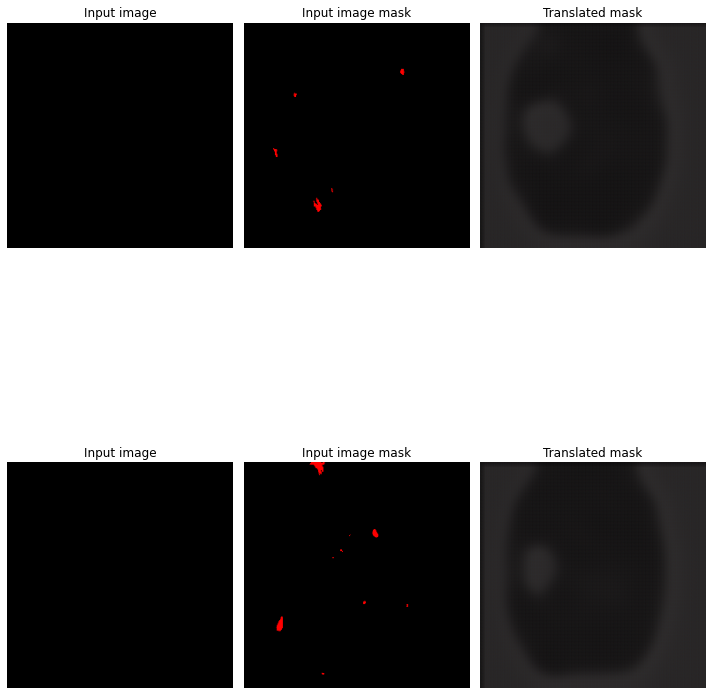

Epoch 2/100
53/53 [==============================] - 23s 437ms/step - G_loss: 1.8766 - F_loss: 1.6264 - D_X_loss: 0.2190 - D_Y_loss: 0.1779
Epoch 3/100
53/53 [==============================] - 23s 436ms/step - G_loss: 0.9363 - F_loss: 0.4825 - D_X_loss: 0.2449 - D_Y_loss: 0.1533
Epoch 4/100
53/53 [==============================] - 23s 437ms/step - G_loss: 0.8885 - F_loss: 0.3118 - D_X_loss: 0.2490 - D_Y_loss: 0.0865
Epoch 5/100
53/53 [==============================] - 23s 436ms/step - G_loss: 0.9083 - F_loss: 0.2612 - D_X_loss: 0.2499 - D_Y_loss: 0.0705
Epoch 6/100
53/53 [==============================] - 23s 436ms/step - G_loss: 0.9827 - F_loss: 0.2544 - D_X_loss: 0.2501 - D_Y_loss: 0.0347


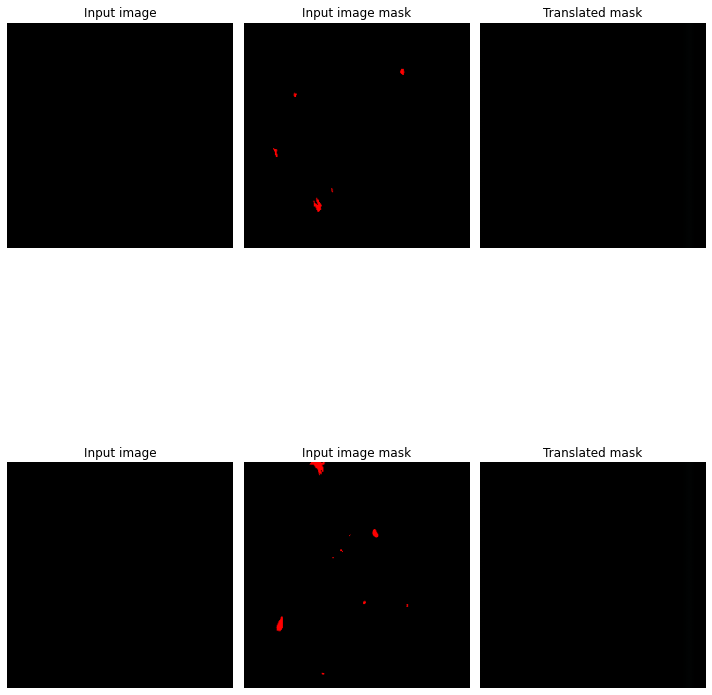

Epoch 7/100
53/53 [==============================] - 23s 437ms/step - G_loss: 1.0615 - F_loss: 0.2537 - D_X_loss: 0.2502 - D_Y_loss: 0.0166
Epoch 8/100
53/53 [==============================] - 23s 437ms/step - G_loss: 1.0430 - F_loss: 0.2545 - D_X_loss: 0.2499 - D_Y_loss: 0.0346
Epoch 9/100
53/53 [==============================] - 23s 436ms/step - G_loss: 1.0813 - F_loss: 0.2527 - D_X_loss: 0.2501 - D_Y_loss: 0.0214
Epoch 10/100
53/53 [==============================] - 23s 437ms/step - G_loss: 0.7133 - F_loss: 0.2532 - D_X_loss: 0.2501 - D_Y_loss: 0.1599
Epoch 11/100
53/53 [==============================] - 23s 433ms/step - G_loss: 0.9863 - F_loss: 0.2529 - D_X_loss: 0.2506 - D_Y_loss: 0.0516


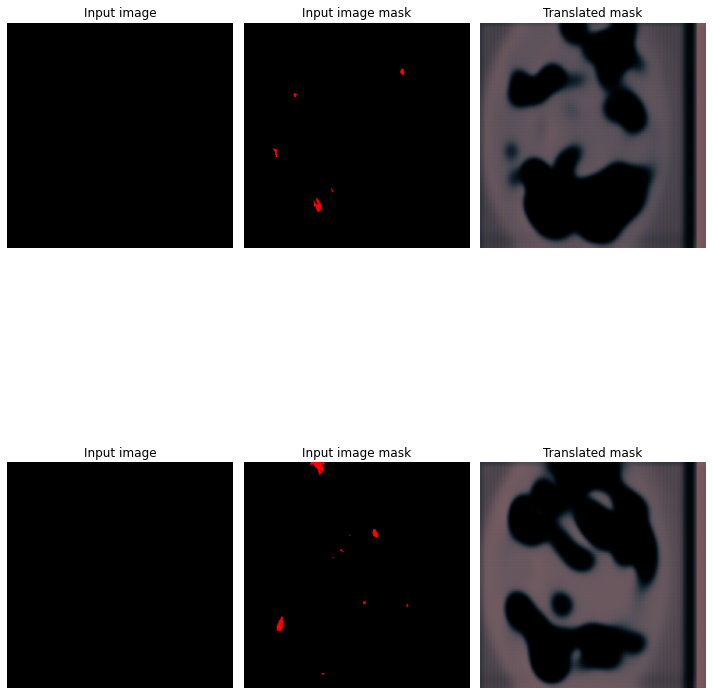

Epoch 12/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.9894 - F_loss: 0.2534 - D_X_loss: 0.2500 - D_Y_loss: 0.0373
Epoch 13/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.0996 - F_loss: 0.2532 - D_X_loss: 0.2500 - D_Y_loss: 0.0091
Epoch 14/100
53/53 [==============================] - 23s 437ms/step - G_loss: 1.0630 - F_loss: 0.2534 - D_X_loss: 0.2500 - D_Y_loss: 0.0268
Epoch 15/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.9692 - F_loss: 0.2535 - D_X_loss: 0.2499 - D_Y_loss: 0.0656
Epoch 16/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.0137 - F_loss: 0.2535 - D_X_loss: 0.2498 - D_Y_loss: 0.0408


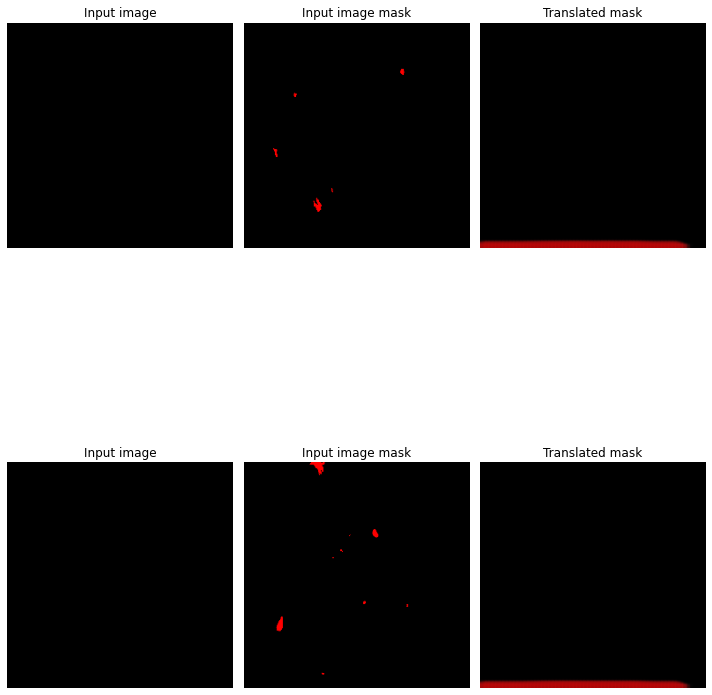

Epoch 17/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.7758 - F_loss: 0.2536 - D_X_loss: 0.2496 - D_Y_loss: 0.0962
Epoch 18/100
53/53 [==============================] - 23s 437ms/step - G_loss: 0.5037 - F_loss: 0.2550 - D_X_loss: 0.2492 - D_Y_loss: 0.1840
Epoch 19/100
53/53 [==============================] - 23s 437ms/step - G_loss: 0.5997 - F_loss: 0.2573 - D_X_loss: 0.2485 - D_Y_loss: 0.1650
Epoch 20/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.0734 - F_loss: 0.2638 - D_X_loss: 0.2465 - D_Y_loss: 0.0257
Epoch 21/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.9980 - F_loss: 0.2773 - D_X_loss: 0.2415 - D_Y_loss: 0.0706


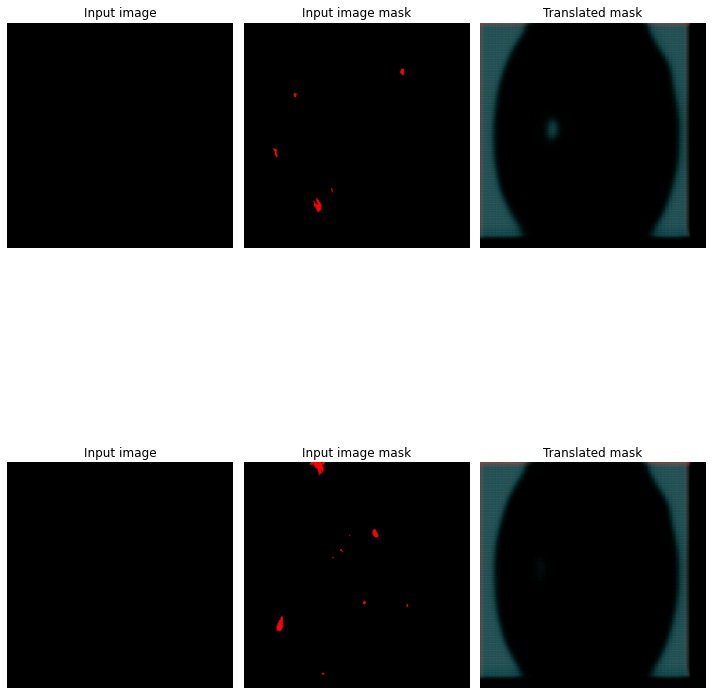

Epoch 22/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.0009 - F_loss: 0.3094 - D_X_loss: 0.2211 - D_Y_loss: 0.0431
Epoch 23/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.1228 - F_loss: 0.3665 - D_X_loss: 0.1988 - D_Y_loss: 0.0065
Epoch 24/100
53/53 [==============================] - 23s 436ms/step - G_loss: 1.1263 - F_loss: 0.3852 - D_X_loss: 0.1906 - D_Y_loss: 0.0042
Epoch 25/100
53/53 [==============================] - 23s 437ms/step - G_loss: 1.1295 - F_loss: 0.4518 - D_X_loss: 0.1592 - D_Y_loss: 0.0032
Epoch 26/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.1306 - F_loss: 0.4426 - D_X_loss: 0.1671 - D_Y_loss: 0.0028


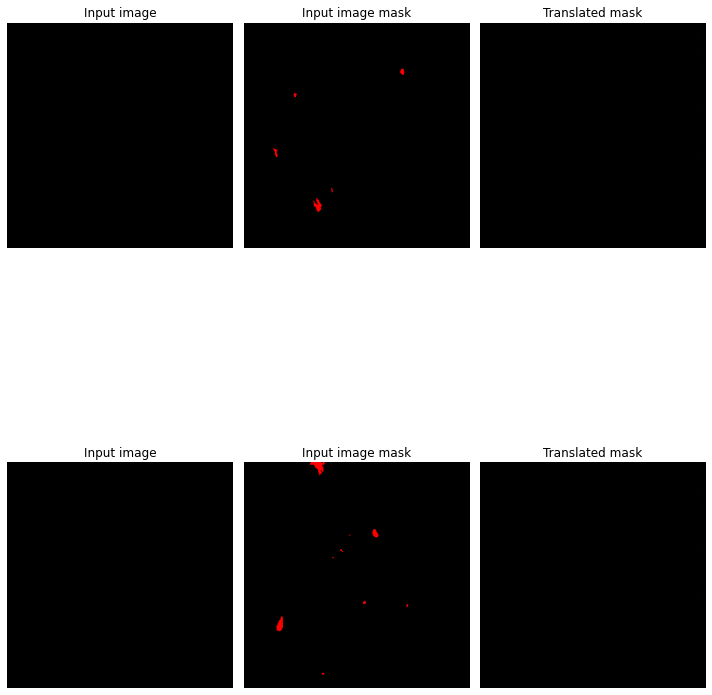

Epoch 27/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.1373 - F_loss: 0.4325 - D_X_loss: 0.1801 - D_Y_loss: 0.0035
Epoch 28/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.1369 - F_loss: 0.4089 - D_X_loss: 0.1839 - D_Y_loss: 0.0023
Epoch 29/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.1289 - F_loss: 0.4225 - D_X_loss: 0.1901 - D_Y_loss: 0.0017
Epoch 30/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.1267 - F_loss: 0.3931 - D_X_loss: 0.1926 - D_Y_loss: 0.0015
Epoch 31/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.6643 - F_loss: 0.3729 - D_X_loss: 0.2062 - D_Y_loss: 0.1766


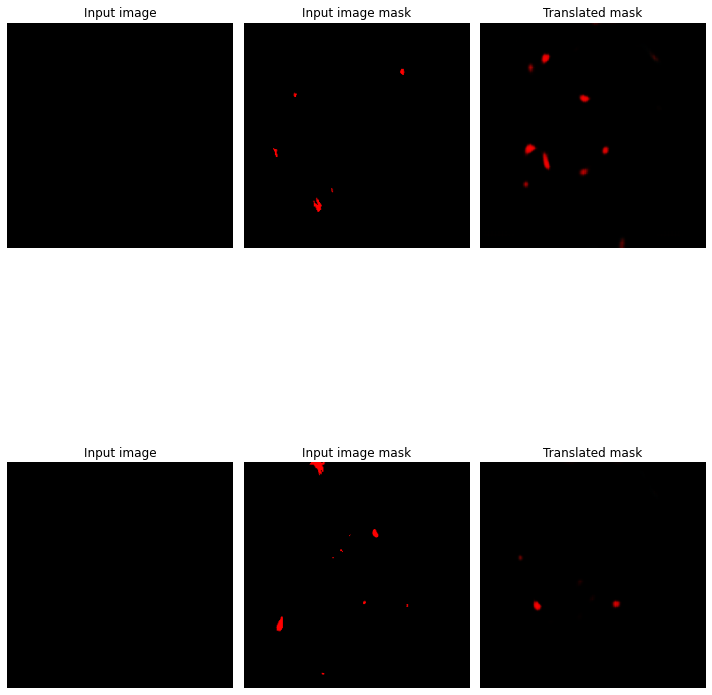

Epoch 32/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.6573 - F_loss: 0.3518 - D_X_loss: 0.2133 - D_Y_loss: 0.1668
Epoch 33/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.7516 - F_loss: 0.3425 - D_X_loss: 0.2166 - D_Y_loss: 0.1285
Epoch 34/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.6199 - F_loss: 0.3333 - D_X_loss: 0.2223 - D_Y_loss: 0.1948
Epoch 35/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.9753 - F_loss: 0.3241 - D_X_loss: 0.2202 - D_Y_loss: 0.0579
Epoch 36/100
53/53 [==============================] - 23s 437ms/step - G_loss: 1.1217 - F_loss: 0.3146 - D_X_loss: 0.2295 - D_Y_loss: 0.0056


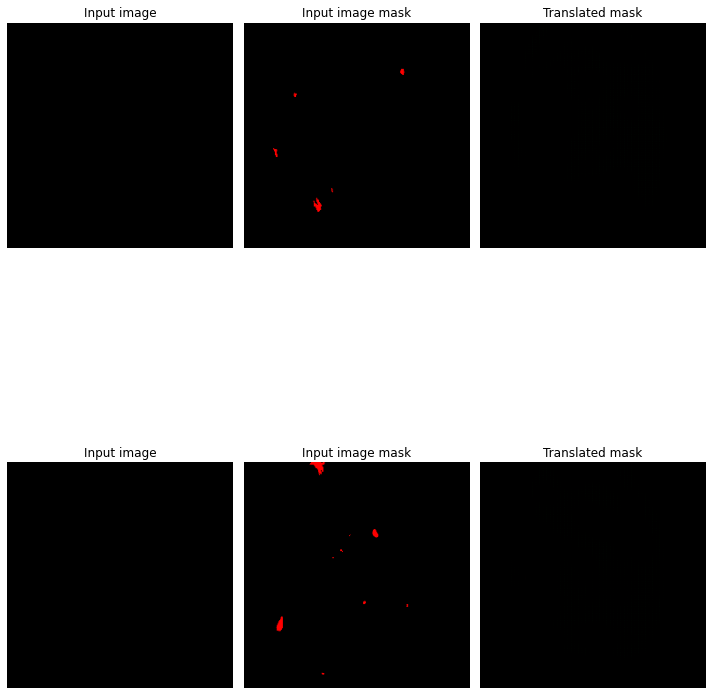

Epoch 37/100
53/53 [==============================] - 23s 437ms/step - G_loss: 0.9374 - F_loss: 0.3182 - D_X_loss: 0.2245 - D_Y_loss: 0.0680
Epoch 38/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.1273 - F_loss: 0.3130 - D_X_loss: 0.2267 - D_Y_loss: 0.0031
Epoch 39/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.1295 - F_loss: 0.3037 - D_X_loss: 0.2306 - D_Y_loss: 0.0022
Epoch 40/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.1306 - F_loss: 0.3184 - D_X_loss: 0.2231 - D_Y_loss: 0.0018
Epoch 41/100
53/53 [==============================] - 23s 437ms/step - G_loss: 1.0188 - F_loss: 0.3233 - D_X_loss: 0.2241 - D_Y_loss: 0.0168


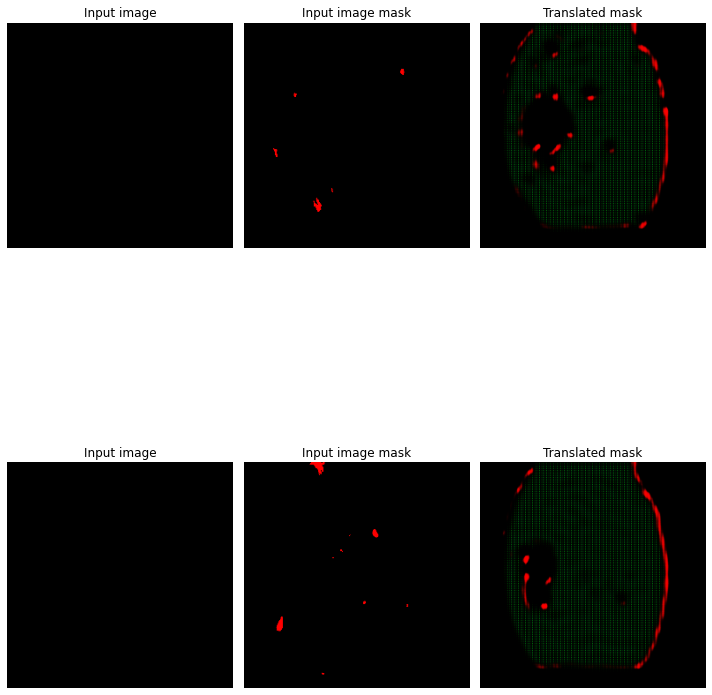

Epoch 42/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.6191 - F_loss: 0.3121 - D_X_loss: 0.2261 - D_Y_loss: 0.1696
Epoch 43/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.9827 - F_loss: 0.3003 - D_X_loss: 0.2310 - D_Y_loss: 0.0508
Epoch 44/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.0099 - F_loss: 0.2980 - D_X_loss: 0.2324 - D_Y_loss: 0.0551
Epoch 45/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.1279 - F_loss: 0.2976 - D_X_loss: 0.2311 - D_Y_loss: 0.0056
Epoch 46/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.1284 - F_loss: 0.2990 - D_X_loss: 0.2305 - D_Y_loss: 0.0038


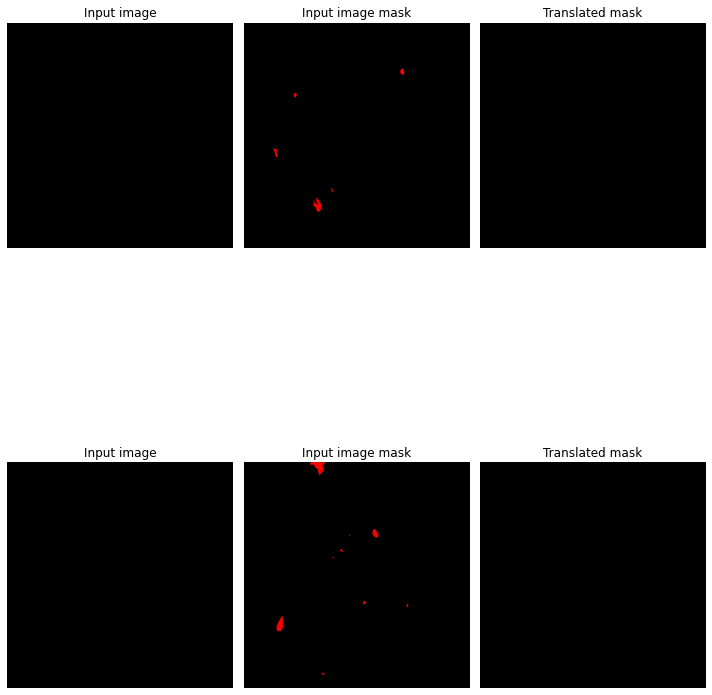

Epoch 47/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.1321 - F_loss: 0.3128 - D_X_loss: 0.2243 - D_Y_loss: 0.0026
Epoch 48/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.1306 - F_loss: 0.3028 - D_X_loss: 0.2301 - D_Y_loss: 0.0021
Epoch 49/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.1313 - F_loss: 0.3142 - D_X_loss: 0.2226 - D_Y_loss: 0.0017
Epoch 50/100
53/53 [==============================] - 23s 436ms/step - G_loss: 0.9833 - F_loss: 0.3082 - D_X_loss: 0.2273 - D_Y_loss: 0.0568
Epoch 51/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.3851 - F_loss: 0.3038 - D_X_loss: 0.2290 - D_Y_loss: 0.2540


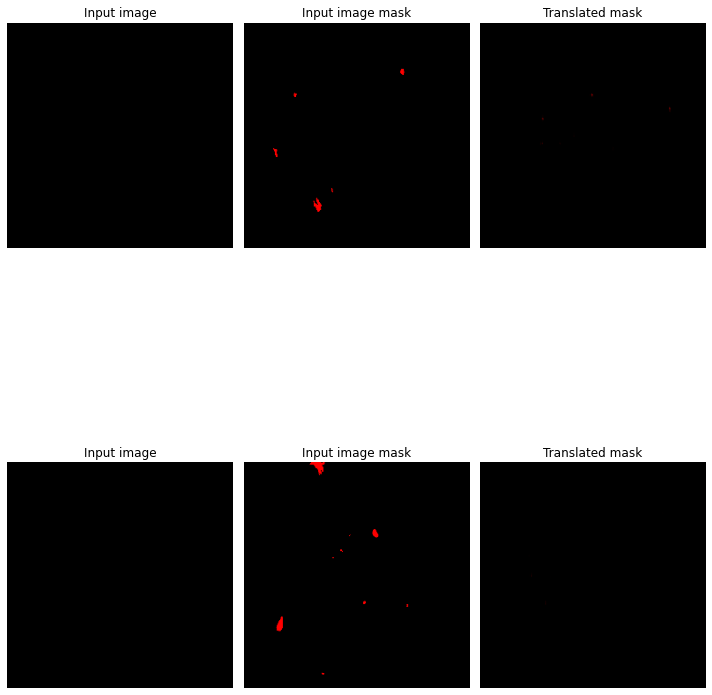

Epoch 52/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.4721 - F_loss: 0.3019 - D_X_loss: 0.2315 - D_Y_loss: 0.2219
Epoch 53/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.4689 - F_loss: 0.2997 - D_X_loss: 0.2333 - D_Y_loss: 0.2408
Epoch 54/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.6351 - F_loss: 0.3013 - D_X_loss: 0.2310 - D_Y_loss: 0.1653
Epoch 55/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.5673 - F_loss: 0.3000 - D_X_loss: 0.2316 - D_Y_loss: 0.2000
Epoch 56/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.3808 - F_loss: 0.3029 - D_X_loss: 0.2309 - D_Y_loss: 0.2586


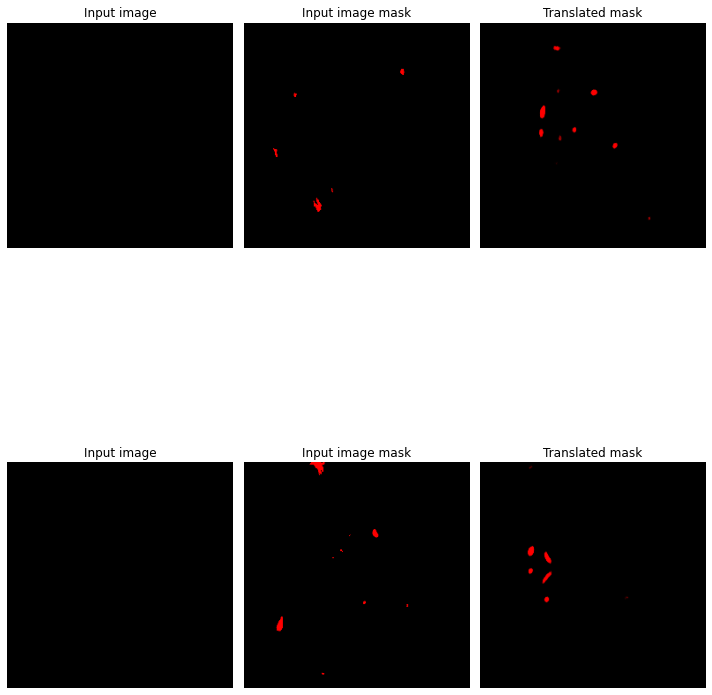

Epoch 57/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.4088 - F_loss: 0.3031 - D_X_loss: 0.2306 - D_Y_loss: 0.2400
Epoch 58/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.4025 - F_loss: 0.3025 - D_X_loss: 0.2293 - D_Y_loss: 0.2475
Epoch 59/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.3889 - F_loss: 0.3059 - D_X_loss: 0.2274 - D_Y_loss: 0.2486
Epoch 60/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.5061 - F_loss: 0.3081 - D_X_loss: 0.2273 - D_Y_loss: 0.1888
Epoch 61/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.5879 - F_loss: 0.3071 - D_X_loss: 0.2281 - D_Y_loss: 0.1606


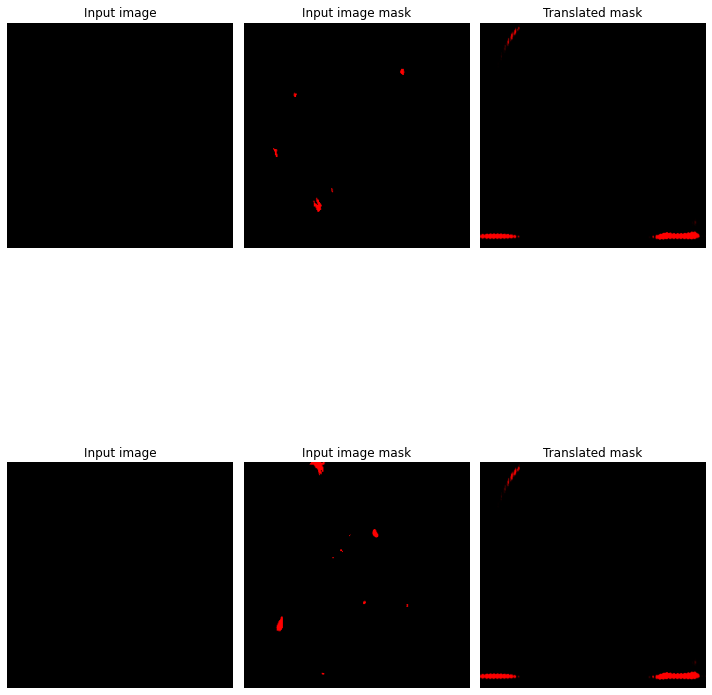

Epoch 62/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.6226 - F_loss: 0.3078 - D_X_loss: 0.2271 - D_Y_loss: 0.1623
Epoch 63/100
53/53 [==============================] - 23s 437ms/step - G_loss: 0.4667 - F_loss: 0.3022 - D_X_loss: 0.2308 - D_Y_loss: 0.2237
Epoch 64/100
53/53 [==============================] - 23s 436ms/step - G_loss: 0.4173 - F_loss: 0.3061 - D_X_loss: 0.2276 - D_Y_loss: 0.2384
Epoch 65/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.3772 - F_loss: 0.3112 - D_X_loss: 0.2250 - D_Y_loss: 0.2623
Epoch 66/100
53/53 [==============================] - 23s 440ms/step - G_loss: 0.4338 - F_loss: 0.3105 - D_X_loss: 0.2253 - D_Y_loss: 0.2299


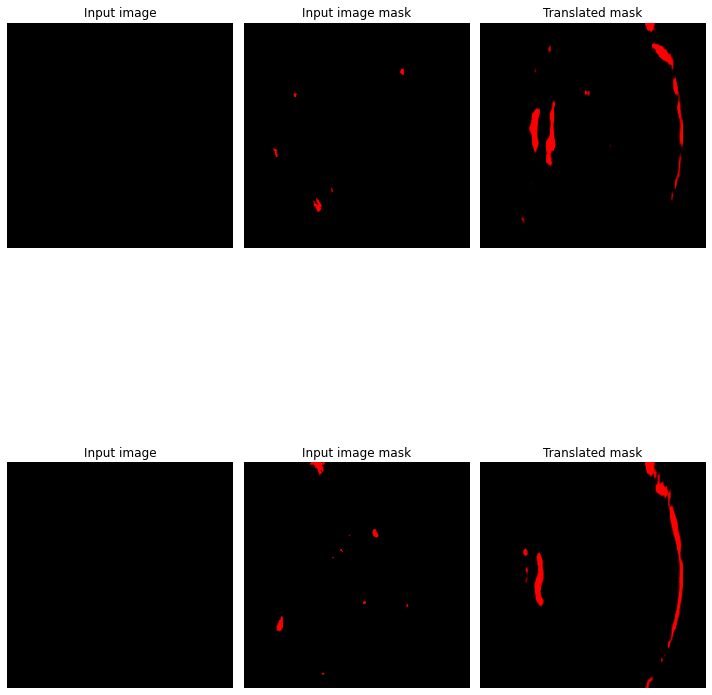

Epoch 67/100
53/53 [==============================] - 23s 440ms/step - G_loss: 0.3831 - F_loss: 0.3140 - D_X_loss: 0.2227 - D_Y_loss: 0.2552
Epoch 68/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.3916 - F_loss: 0.3769 - D_X_loss: 0.1959 - D_Y_loss: 0.2451
Epoch 69/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.3893 - F_loss: 0.3423 - D_X_loss: 0.2072 - D_Y_loss: 0.2473
Epoch 70/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.3999 - F_loss: 0.3314 - D_X_loss: 0.2166 - D_Y_loss: 0.2373
Epoch 71/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.3914 - F_loss: 0.3283 - D_X_loss: 0.2190 - D_Y_loss: 0.2439


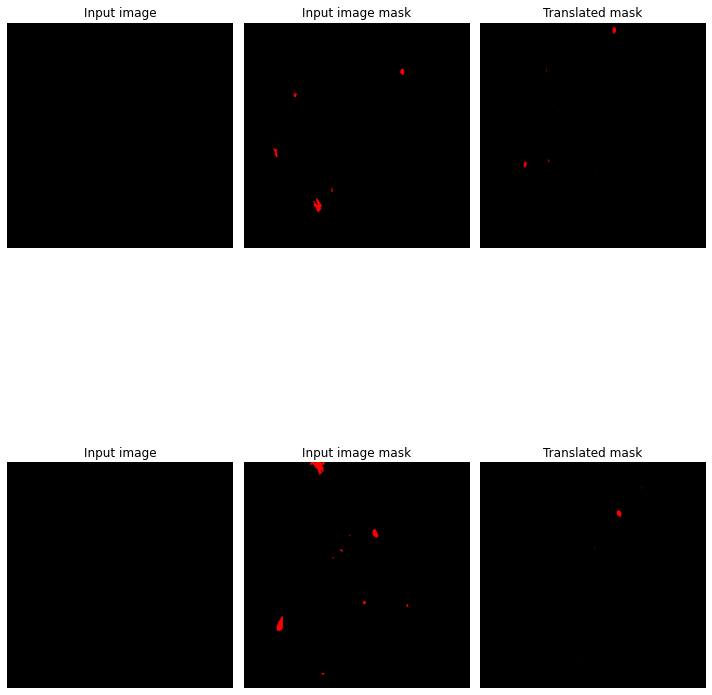

Epoch 72/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.3938 - F_loss: 0.3262 - D_X_loss: 0.2174 - D_Y_loss: 0.2457
Epoch 73/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.4544 - F_loss: 0.3295 - D_X_loss: 0.2175 - D_Y_loss: 0.2103
Epoch 74/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.4213 - F_loss: 0.3248 - D_X_loss: 0.2189 - D_Y_loss: 0.2448
Epoch 75/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.4031 - F_loss: 0.3290 - D_X_loss: 0.2174 - D_Y_loss: 0.2443
Epoch 76/100
53/53 [==============================] - 23s 437ms/step - G_loss: 0.4268 - F_loss: 0.3399 - D_X_loss: 0.2153 - D_Y_loss: 0.2319


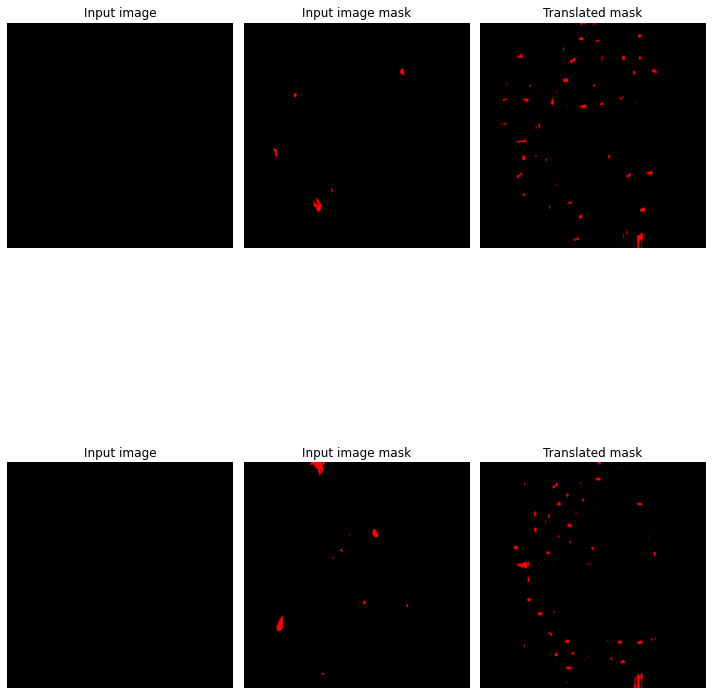

Epoch 77/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.4028 - F_loss: 0.3494 - D_X_loss: 0.2084 - D_Y_loss: 0.2446
Epoch 78/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.4414 - F_loss: 0.3399 - D_X_loss: 0.2090 - D_Y_loss: 0.2153
Epoch 79/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.4315 - F_loss: 0.3346 - D_X_loss: 0.2139 - D_Y_loss: 0.2224
Epoch 80/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.5800 - F_loss: 0.3479 - D_X_loss: 0.3001 - D_Y_loss: 0.1565
Epoch 81/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.9282 - F_loss: 0.2560 - D_X_loss: 0.2496 - D_Y_loss: 0.0525


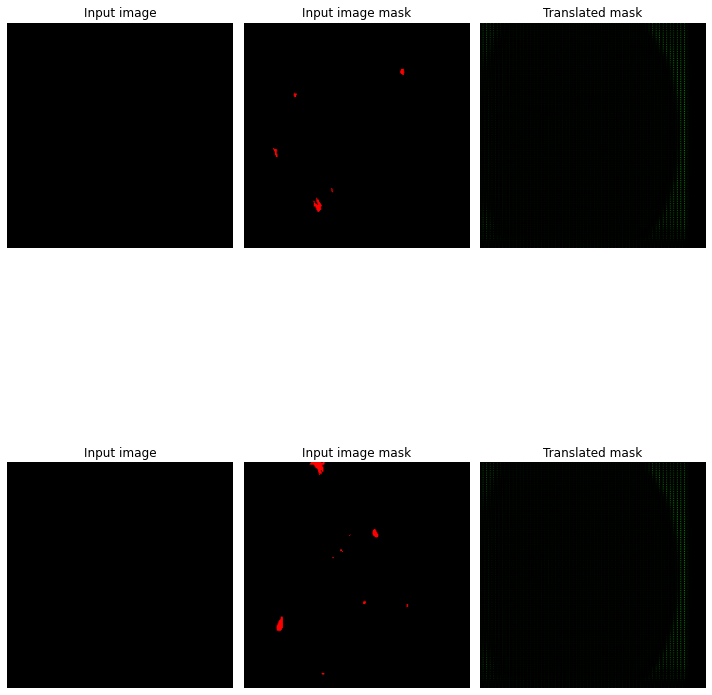

Epoch 82/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.0157 - F_loss: 0.2552 - D_X_loss: 0.2498 - D_Y_loss: 0.0228
Epoch 83/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.0246 - F_loss: 0.2541 - D_X_loss: 0.2502 - D_Y_loss: 0.0360
Epoch 84/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.9016 - F_loss: 0.2548 - D_X_loss: 0.2499 - D_Y_loss: 0.0615
Epoch 85/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.0405 - F_loss: 0.2555 - D_X_loss: 0.2495 - D_Y_loss: 0.0299
Epoch 86/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.1078 - F_loss: 0.2546 - D_X_loss: 0.2493 - D_Y_loss: 0.0151


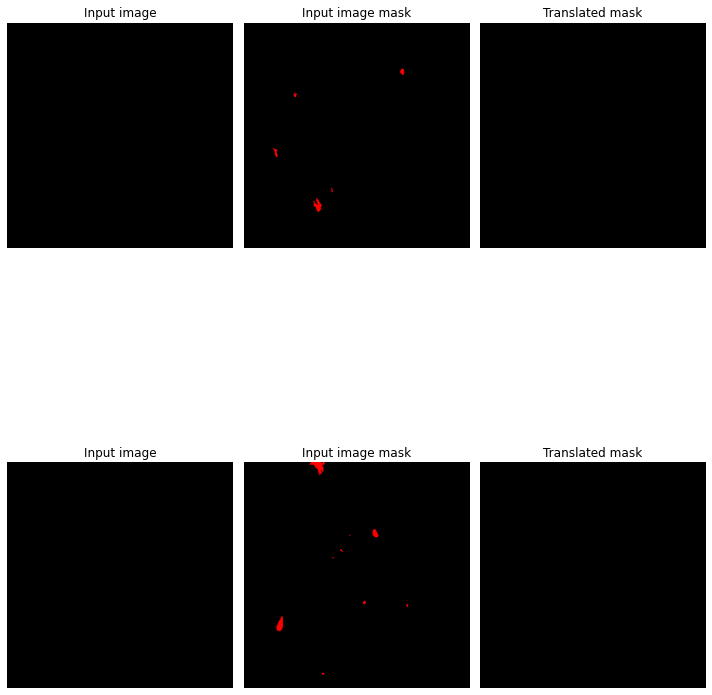

Epoch 87/100
53/53 [==============================] - 23s 438ms/step - G_loss: 1.1121 - F_loss: 0.2546 - D_X_loss: 0.2493 - D_Y_loss: 0.0084
Epoch 88/100
53/53 [==============================] - 23s 440ms/step - G_loss: 1.1007 - F_loss: 0.2557 - D_X_loss: 0.2493 - D_Y_loss: 0.0285
Epoch 89/100
53/53 [==============================] - 23s 436ms/step - G_loss: 1.0764 - F_loss: 0.2551 - D_X_loss: 0.2492 - D_Y_loss: 0.0202
Epoch 90/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.1286 - F_loss: 0.2549 - D_X_loss: 0.2493 - D_Y_loss: 0.0039
Epoch 91/100
53/53 [==============================] - 23s 439ms/step - G_loss: 1.0541 - F_loss: 0.2552 - D_X_loss: 0.2491 - D_Y_loss: 0.0279


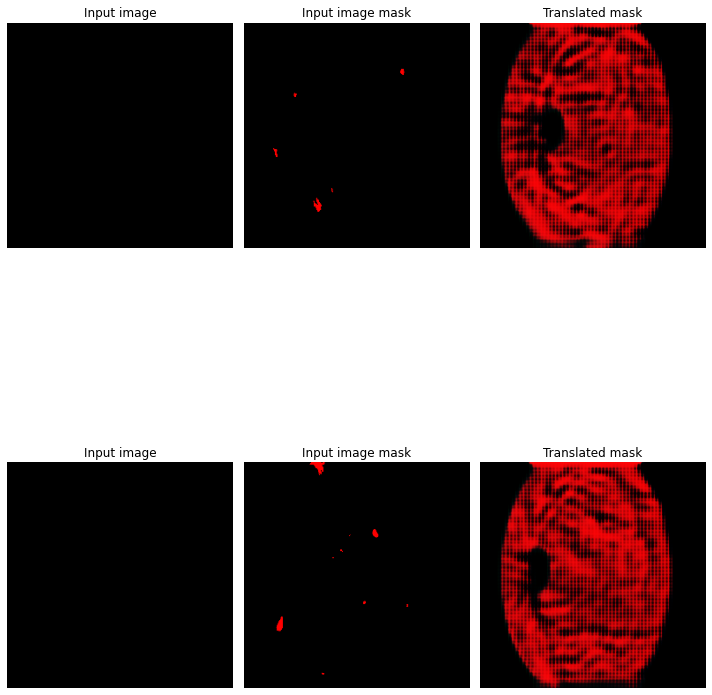

Epoch 92/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.5730 - F_loss: 0.2556 - D_X_loss: 0.2491 - D_Y_loss: 0.1810
Epoch 93/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.4118 - F_loss: 0.2557 - D_X_loss: 0.2490 - D_Y_loss: 0.2385
Epoch 94/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.4306 - F_loss: 0.2556 - D_X_loss: 0.2489 - D_Y_loss: 0.2229
Epoch 95/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.5459 - F_loss: 0.2567 - D_X_loss: 0.2496 - D_Y_loss: 0.1763
Epoch 96/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.5200 - F_loss: 0.2557 - D_X_loss: 0.2486 - D_Y_loss: 0.1926


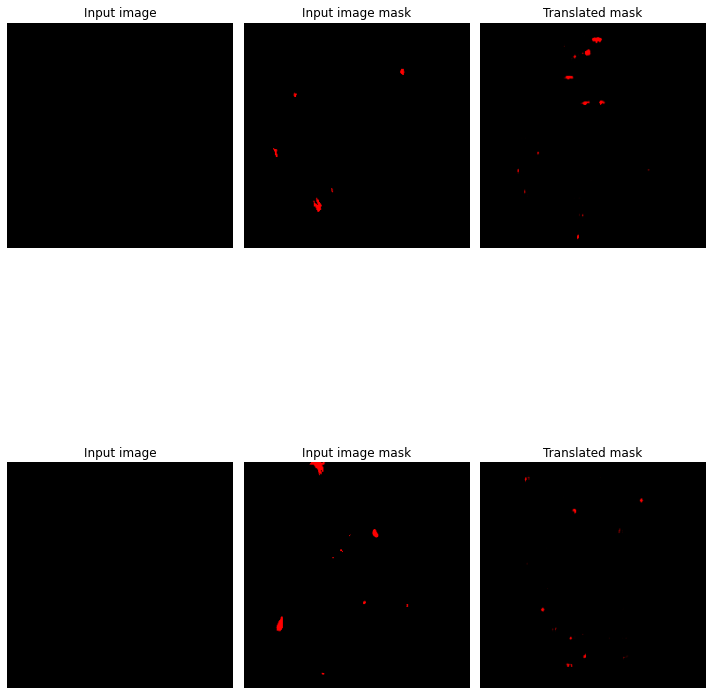

Epoch 97/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.5359 - F_loss: 0.2559 - D_X_loss: 0.2486 - D_Y_loss: 0.1758
Epoch 98/100
53/53 [==============================] - 23s 438ms/step - G_loss: 0.6066 - F_loss: 0.2562 - D_X_loss: 0.2485 - D_Y_loss: 0.1656
Epoch 99/100
53/53 [==============================] - 23s 440ms/step - G_loss: 0.6078 - F_loss: 0.2567 - D_X_loss: 0.2491 - D_Y_loss: 0.1596
Epoch 100/100
53/53 [==============================] - 23s 439ms/step - G_loss: 0.6164 - F_loss: 0.2568 - D_X_loss: 0.2486 - D_Y_loss: 0.1533


In [ ]:

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_img, train_msk,train_unlabeled)),
    epochs=100,
    callbacks=[plotter, model_checkpoint_callback],
)

In [ ]:

# Load the checkpoints
weight_file = "./saved_checkpoints/cyclegan_checkpoints.020"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

_, ax = plt.subplots(4, 3, figsize=(10, 15))
for i, samples in enumerate(zip(test_img.take(4), test_msk.take(4))):
    prediction = cycle_gan_model.gen_G(samples[0], training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (samples[0][0] * 127.5 + 127.5).numpy().astype(np.uint8)
    msk = (samples[1][0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(msk)
    ax[i, 2].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Input image mask")
    ax[i, 2].set_title("Translated mask")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()